In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from urllib.request import urlopen
from PIL import Image
from torchvision import transforms
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset, random_split
import pandas as pd


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225]),
])

/rds/general/user/ms7024/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [3]:
# Define custom dataset

class BreakHisDataset(Dataset): # Subclass Dataset, which is required for using DataLoader
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

dataset_train = BreakHisDataset(csv_path="../data/augmented_train_dataset.csv", transform=transform) # Load the data
dataset_test = BreakHisDataset(csv_path="../data/new_test.csv", transform=transform)

# Create iterable data loaders

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False) # shuffle=False for consistent evaluation

In [6]:
# Load the pre-trained model

model = timm.create_model('convnextv2_atto.fcmae', pretrained=True, num_classes=2)

# Freeze all layers (can then unfreeze sequentially)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in model.head.parameters():
    param.requires_grad = True
    
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.head.parameters(), lr=1e-3)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

In [7]:
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item() * images.size(0) # Accumulate loss
        
        _, preds = torch.max(outputs, 1) # Take the maximum one as the class with the highest predicted probability => predicted class
        correct += (preds == labels).sum().item() # Number of correct predictions 
        total += labels.size(0) # adding correct predictions
        
    # Update training losses / accuracies
    
    epoch_train_loss = running_loss / total
    train_losses.append(epoch_train_loss)
    
    epoch_train_acc = correct / total
    train_accuracies.append(epoch_train_acc)
    
    # Evaluation phase
    
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    epoch_val_acc = correct_val / total_val
    epoch_val_loss = running_val_loss / total_val
    val_accuracies.append(epoch_val_acc)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Train loss: {epoch_train_loss}, Test loss: {epoch_val_loss} Train accuracy: {epoch_train_acc}, Test accuracy: {epoch_val_acc}")


Epoch [1/10], Train loss: 0.4682010176460358, Test loss: 0.4780031360248738 Train accuracy: 0.7957044673539518, Test accuracy: 0.7747808496291302
Epoch [2/10], Train loss: 0.4018905411368793, Test loss: 0.44008527835799643 Train accuracy: 0.8281786941580757, Test accuracy: 0.8024275118004046
Epoch [3/10], Train loss: 0.3753789940138453, Test loss: 0.4038785001512966 Train accuracy: 0.8429553264604811, Test accuracy: 0.8341200269723533
Epoch [4/10], Train loss: 0.3579722831544188, Test loss: 0.3990984436071811 Train accuracy: 0.8546391752577319, Test accuracy: 0.8361429534726905
Epoch [5/10], Train loss: 0.3445373062415631, Test loss: 0.39741796882105934 Train accuracy: 0.8604810996563574, Test accuracy: 0.839514497639919
Epoch [6/10], Train loss: 0.33236337740396715, Test loss: 0.3779990894924686 Train accuracy: 0.868213058419244, Test accuracy: 0.8442346594740391
Epoch [7/10], Train loss: 0.3239141200313863, Test loss: 0.3727940778955767 Train accuracy: 0.8719931271477663, Test accura

In [ ]:
# Looping over different model architectures

In [5]:
n_epochs = 10

models = ['Head only', 'Stage 4', 'Stages 3-4', 'Stages 2-4', 'Stages 1-4']
perf_train = pd.DataFrame(index=range(n_epochs), columns=models)
perf_test = pd.DataFrame(index=range(n_epochs), columns=models)

# Initialise loss criterion & optimiser
criterion = nn.CrossEntropyLoss()

# Sequentially unfreeze stages from top down

n_stages = 4

for i in range(n_stages+1):
    
    # Initialise model
    
    model = timm.create_model('convnextv2_atto.fcmae', pretrained=True, num_classes=2)
    optimiser = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], 
        lr=1e-4)
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.head.parameters():
        param.requires_grad = True
    
    n_stages_to_unfreeze = i
    print(f' {i}. Stages to unfreeze: {i}')
    
    # Unfreeze stages
    for a in range(n_stages - n_stages_to_unfreeze, n_stages):
        for param in model.stages[a].parameters():
            param.requires_grad = True
    
    # Initialise tracking 
    
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            optimiser.zero_grad()
            pred = model(images) # forward pass
            loss = criterion(pred, labels) 
            loss.backward() # updates model.grad with partial derivatives calc via chain rule
            optimiser.step() # take a step in negative direction of grad using calculated derivatives
            
            running_loss += loss.item() * images.size(0) # Accumulate loss per batch
            
            _, preds = torch.max(pred, 1) # Take the maximum one as the class with the highest predicted probability => predicted class
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_train_loss = running_loss/total
        train_losses.append(epoch_train_loss)
        
        epoch_train_accuracy = correct/total 
        train_accuracies.append(epoch_train_accuracy)
        
        model.eval()
        
        running_loss_test = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                pred = model(images)
                loss = criterion(pred, labels)
                running_loss_test += loss.item() * images.size(0)
                _, preds = torch.max(pred,1)
                
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
            
            
        test_losses.append(running_loss_test/total_test)
            
        epoch_test_accuracy = correct_test/total_test
        test_accuracies.append(epoch_test_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs}: Train Accuracy {epoch_train_accuracy}, Test Accuracy {epoch_test_accuracy}")
    
    perf_train.iloc[:,i] = train_accuracies
    perf_test.iloc[:,i] = test_accuracies

perf_train.to_csv('convnext_v2_outputs/arc_perf_train.csv')
perf_test.to_csv('convnext_v2_outputs/arc_perf_test.csv')
print(perf_train)
print(perf_test)

 0. Stages to unfreeze: 0
Epoch 1/10: Train Accuracy 0.761168384879725, Test Accuracy 0.8206338503034389
Epoch 2/10: Train Accuracy 0.7903780068728522, Test Accuracy 0.8125421443020904
Epoch 3/10: Train Accuracy 0.7974226804123712, Test Accuracy 0.7896156439649359
Epoch 4/10: Train Accuracy 0.802405498281787, Test Accuracy 0.803776129467296
Epoch 5/10: Train Accuracy 0.8072164948453608, Test Accuracy 0.8017532029669588
Epoch 6/10: Train Accuracy 0.8115120274914089, Test Accuracy 0.8138907619689818
Epoch 7/10: Train Accuracy 0.8163230240549828, Test Accuracy 0.8071476736345247
Epoch 8/10: Train Accuracy 0.8168384879725086, Test Accuracy 0.815913688469319
Epoch 9/10: Train Accuracy 0.8194158075601374, Test Accuracy 0.813216453135536
Epoch 10/10: Train Accuracy 0.8235395189003436, Test Accuracy 0.8172623061362104
 1. Stages to unfreeze: 1
Epoch 1/10: Train Accuracy 0.8493127147766323, Test Accuracy 0.8678354686446392
Epoch 2/10: Train Accuracy 0.9, Test Accuracy 0.8725556304787593
Epoch 3

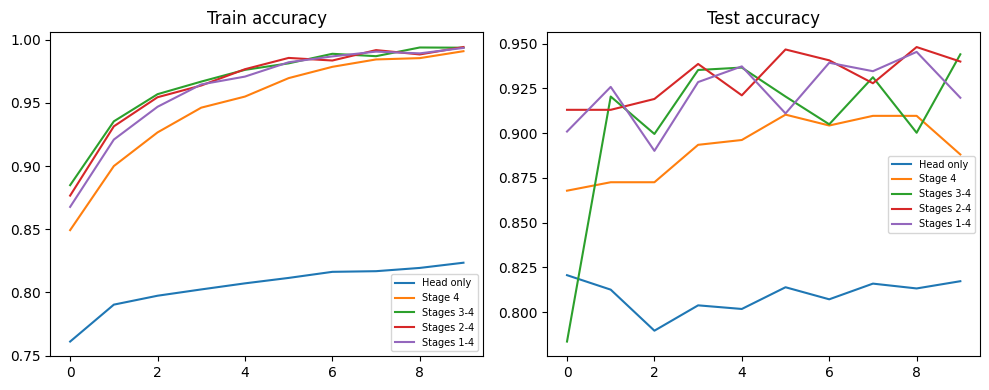

In [9]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))

for i, df in enumerate([perf_train, perf_test]):
    
    for col in df.columns:
        ax[i].plot(range(perf_test.shape[0]), df.loc[:, col], label = col)
    
    if i == 0:
        ax[i].set_title("Train accuracy")
    else:
        ax[i].set_title("Test accuracy")
    
    ax[i].legend(prop={'size': 7})

plt.tight_layout()
plt.savefig("unfreeze_accuracy.png") 
plt.show()